In [61]:
from collections import deque
import tqdm
import bench_utils
from shapely.geometry import shape
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
import random
import numpy as np
from shapely.geometry import shape

fpd = FpdExtended()

df, unary_idxs = bench_utils.read_dataset()
unary_idxs = list(set(unary_idxs))

MEMORY_SLOTS = 5
# Export delta properties
X, y = [], []
for idx in tqdm.tqdm(unary_idxs, disable=True): # List of single idxs
    _, bin = fpd.compress(shape(df.iloc[idx]))
    chunks, _ = fpd.get_chunks(bin, include_ring_start=False)

    for c in chunks:
        #prevs = [(0, *c[0])]
        prevs = [c[0]]
        for coord in c[1:]:
            #point = (0, *coord)

            if len(prevs) > MEMORY_SLOTS:
                prevs.pop()

            X_small = [prevs[i] if len(prevs) > i else [0, 0] for i in range(MEMORY_SLOTS)]
            y_small = coord
            prevs.insert(0, coord)
            X.append(X_small)
            y.append(y_small)

In [62]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
X = np.array(X)
y = np.array(y)

In [63]:
print(X.shape)
#X = X.reshape((-1, X.shape[1] * X.shape[2]))
#print(X.shape)
print(y.shape)

(64541, 5, 2)
(64541, 2)


In [64]:
print(X)
print(y)

[[[13.1854398 55.706723 ]
  [ 0.         0.       ]
  [ 0.         0.       ]
  [ 0.         0.       ]
  [ 0.         0.       ]]

 [[13.185471  55.7068707]
  [13.1854398 55.706723 ]
  [ 0.         0.       ]
  [ 0.         0.       ]
  [ 0.         0.       ]]

 [[13.1854744 55.7068789]
  [13.185471  55.7068707]
  [13.1854398 55.706723 ]
  [ 0.         0.       ]
  [ 0.         0.       ]]

 ...

 [[13.1798695 55.6964445]
  [13.1798976 55.6964358]
  [13.1799244 55.6964233]
  [13.1799425 55.6964074]
  [13.1799506 55.6963908]]

 [[13.1798131 55.6964562]
  [13.1798695 55.6964445]
  [13.1798976 55.6964358]
  [13.1799244 55.6964233]
  [13.1799425 55.6964074]]

 [[13.1797642 55.6964622]
  [13.1798131 55.6964562]
  [13.1798695 55.6964445]
  [13.1798976 55.6964358]
  [13.1799244 55.6964233]]]
[[13.185471  55.7068707]
 [13.1854744 55.7068789]
 [13.1854789 55.7068869]
 ...
 [13.1798131 55.6964562]
 [13.1797642 55.6964622]
 [13.1797172 55.6964649]]


In [65]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, random_state=50,test_size=0.3)
X_validation, X_test, y_validation, y_test = model_selection.train_test_split(X_validation, y_validation, random_state=50,test_size=0.3)

print('train data shape:',np.shape(X_train))
print('validation data shape:',np.shape(X_validation))
print('train labels shape:',np.shape(y_train))
print('validation labels shape:',np.shape(y_validation))
print('test labels shape:',np.shape(X_test))
print('test labels shape:',np.shape(y_test))

train data shape: (45178, 5, 2)
validation data shape: (13554, 5, 2)
train labels shape: (45178, 2)
validation labels shape: (13554, 2)
test labels shape: (5809, 5, 2)
test labels shape: (5809, 2)


In [66]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

#train_data = (train_data-mean) / std
#validation_data = (validation_data-mean) / std

#print(train_data)
print(mean, std)

[[13.19735887 55.70406662]
 [10.85248954 45.80680714]
 [ 8.81114245 37.1906544 ]
 [ 6.96057354 29.37967097]
 [ 5.73774127 24.21835497]] [[1.66484342e-02 8.74099854e-03]
 [5.04455277e+00 2.12922437e+01]
 [6.21668168e+00 2.62397225e+01]
 [6.58871700e+00 2.78100700e+01]
 [6.54221938e+00 2.76139307e+01]]


In [67]:
X_train[0]

array([[13.183625 , 55.6890487],
       [13.1836464, 55.6890002],
       [13.1836858, 55.6890057],
       [13.1836854, 55.6890067],
       [13.1837519, 55.689016 ]])

In [68]:
y_train[0]

array([13.1836551, 55.6890529])

In [69]:
X_validation[0]

array([[13.1794817, 55.7184121],
       [13.1799881, 55.7184892],
       [13.1813358, 55.7187016],
       [13.1835961, 55.719049 ],
       [13.1836985, 55.7190653]])

In [70]:
import gc
gc.collect() # used to clear gpu memory 

0

In [71]:
if False: 
    neural_net = MLPRegressor(max_iter=2000).fit(X_train, y_train)
    ## Result
    y_hat = neural_net.predict(X_validation)

    PRINT_VALIDATION = False

    pred_better_cnt = 0
    for i in range(len(y_hat)):
        prev = X_validation[i][0:2]
        predicted_is_better =  np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
        pred_better_cnt = pred_better_cnt + 1 if predicted_is_better else pred_better_cnt
        if PRINT_VALIDATION:
            print(prev)
            print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
            print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
            print('Better:', 'YES' if predicted_is_better else 'NO')

    print("Model was better in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')

In [72]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, concatenate, Input, Dropout, BatchNormalization

input_shape=(MEMORY_SLOTS, 2)

# Define the model architecture
# model = Sequential()
# model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(2))
model.compile(loss="mean_squared_error", optimizer="adam")

# model = Sequential()
# model.add(LSTM(units=256, input_shape=input_shape, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

2023-04-18 20:54:51.474366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 20:54:51.475659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 20:54:51.476763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [73]:
from keras.callbacks import EarlyStopping

# Define early stopping based on validation error
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

Epoch 1/100


2023-04-18 20:54:51.768188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 20:54:51.769375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 20:54:51.771867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1407/1412 [============================>.] - ETA: 0s - loss: 231.3101

2023-04-18 20:54:56.834345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 20:54:56.836032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 20:54:56.837523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1412/1412 [==============================] - 6s 3ms/step - loss: 230.5226 - val_loss: 0.2838
Epoch 2/100
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0200 - val_loss: 2.0767e-04
Epoch 3/100
1412/1412 [==============================] - 4s 3ms/step - loss: 2.0314e-04 - val_loss: 2.0646e-04
Epoch 4/100
1412/1412 [==============================] - 4s 3ms/step - loss: 2.0315e-04 - val_loss: 2.0512e-04
Epoch 5/100
1412/1412 [==============================] - 4s 3ms/step - loss: 2.0348e-04 - val_loss: 2.0427e-04
Epoch 6/100
1412/1412 [==============================] - 4s 3ms/step - loss: 2.0418e-04 - val_loss: 2.0270e-04
Epoch 7/100
1412/1412 [==============================] - 4s 3ms/step - loss: 2.0561e-04 - val_loss: 2.1614e-04
Epoch 8/100
1412/1412 [==============================] - 4s 3ms/step - loss: 2.1231e-04 - val_loss: 2.1134e-04
Epoch 9/100
1412/1412 [==============================] - 5s 3ms/step - loss: 2.1038e-04 - val_loss: 2.0486e-04
Epoch 10/100
1412/1412 

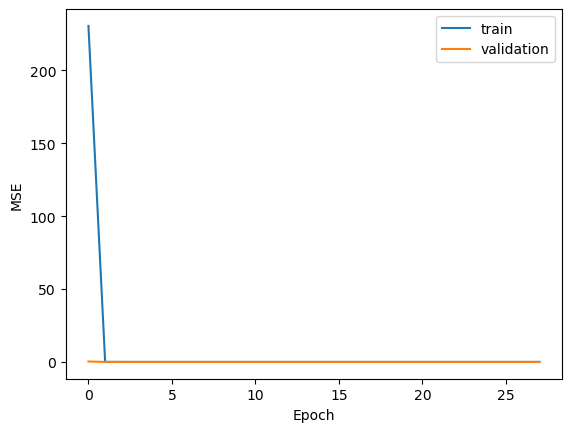

In [74]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [75]:
y_hat = model.predict(X_validation)

def linear_pred(X):
    if X[0][0] == 0:
        return 0
    elif X[1][0] == 0:
        return X[0]
    else:
        return X[0] + (X[1] - X[0])

PRINT_VALIDATION = False

pred_better_cnt = 0
pred_tot_mse = 0
none_tot_mse = 0
lin_better_cnt = 0
lin_tot_mse = 0
# TODO: Use test set instead!
for i in range(len(y_hat)):
    prev = X_validation[i][0]
    predicted_is_better = np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
    pred_better_cnt += 1 if predicted_is_better else 0
    pred_tot_mse += np.linalg.norm(y[i] - y_hat[i])
    none_tot_mse += np.linalg.norm(y[i] - prev)
    if PRINT_VALIDATION:
        print(prev)
        print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
        print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
        print('Better:', 'YES' if predicted_is_better else 'NO')
        print()

    ## Linear Prediction
    y_lin = linear_pred(X_validation[i])
    lin_is_better = np.linalg.norm(y[i] - y_lin) < np.linalg.norm(y[i] - prev)
    lin_better_cnt += 1 if lin_is_better else 0
    lin_tot_mse += np.linalg.norm(y[i] - y_lin)

    if PRINT_VALIDATION:
        print('-- Linear Prediction')
        print(f'{i + 1}: Diff: {y[i] - y_lin}   predicted {y_lin}     distance {np.linalg.norm(y[i] - y_lin)}')
        print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
        print('Better:', 'YES' if lin_is_better else 'NO')
        print()

print("Model was better than None in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')
print("Total MSE Model:", pred_tot_mse)
print("Total MSE None:", none_tot_mse)
print("MSE Ratio (lower means model is better):", f'{(pred_tot_mse/none_tot_mse * 100):f}%')
print()
print("Linear Prediction was better than None in:", lin_better_cnt, '/', len(y_hat), '   (', f'{(lin_better_cnt/len(y_hat) * 100):f}%' , ')')
print("Total MSE Linear:", lin_tot_mse)
print("Total MSE None:", none_tot_mse)
print("MSE Ratio (lower means linear is better):", f'{(lin_tot_mse/none_tot_mse * 100):f}%')

2023-04-18 20:57:46.530927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 20:57:46.532810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 20:57:46.536185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

424/424 [==============================] - 1s 2ms/step
Model was better than None in: 9080 / 13554    ( 66.991294% )
Total MSE Model: 250.75751395867667
Total MSE None: 331.3936080491591
MSE Ratio (lower means model is better): 75.667577%

Linear Prediction was better than None in: 5624 / 13554    ( 41.493286% )
Total MSE Linear: 331.38598047406276
Total MSE None: 331.3936080491591
MSE Ratio (lower means linear is better): 99.997698%
